In [1]:
from math import ceil
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model

from keras_ssd300 import ssd_300
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, greedy_nms
from ssd_batch_generator import BatchGenerator

Using TensorFlow backend.


### 1. Introduction and building the model

The cell below sets a number of parameters that define the model architecture and then calls the function `ssd_300()` to build the model. The parameters as set below produce the original SSD300 architecture that was trained on the Microsoft COCO datset, i.e. they are all chosen to correspond exactly to their respective counterparts in the `.prototxt` file that defines the original Caffe implementation. Note that the anchor box scaling factors of the original SSD implementation vary depending on the datasets on which the authors trained their models. The scaling factors used for the MS COCO dataset are smaller than the scaling factors used for the Pascal VOC datasets, so keep that in mind if you want to reproduce the results from the paper. The scaling factors defined below are for the MS COCO dataset. The scaling factors are hard-coded as absolute pixel values in the `.prototxt`, but the relative scaling factors defined below produce exactly those absolute values at an image size of 300x300. The reason why the list of scaling factors has 7 elements while there are only 6 classifier layers is that the last scaling factor is used for the second aspect-ratio-1 box of the last classifier layer. See the documentation for details.

The original SSD does not clip the anchor box coordinates to lie within the image boundaries, so `limit_boxes` is set to `False`. I don't see the point of having box coordinates that don't lie within the image boundaries and I would generally recommend to limit the boxes, but this is how the original SSD is configured.

Now of course I could just hard-code everything with the original model parameters and this notebook would be a lot cleaner, but the way it's set up here, if you want to train a model with SSD300 architecture from scratch, you can change the configuration with just a few clicks. For example, if you wanted to train a model that is more suitable to detect very small objects, you can just change the scale parameters below accordingly.

The parameters set below are not only needed to build the model, but are also passed to the `SSDBoxEncoder` constructor in the subsequent cell, which is responsible for matching and encoding ground truth boxes and anchor boxes during training. In order to do that, it needs to know the anchor box specifications. It is for the same reason that `ssd_300()` does not only return the model itself, but also `classifier_sizes`, a list of the spatial sizes of the convolutional classifier layers - `SSDBoxEncoder` needs this information to know where the anchor boxes must be placed spatially.

The original Caffe implementation does pretty much everything inside a model layer: The ground truth boxes are matched and encoded inside [MultiBoxLossLayer](https://github.com/weiliu89/caffe/blob/ssd/src/caffe/layers/multibox_loss_layer.cpp), and box decoding, confidence thresholding and non-maximum suppression is performed in [DetectionOutputLayer](https://github.com/weiliu89/caffe/blob/ssd/src/caffe/layers/detection_output_layer.cpp). In contrast to that, in the current form of this implementation, ground truth box matching and encoding happens as part of the mini batch generation (i.e. outside of the model itself). To be specific, `BatchGenerator` calls the `encode_y()` method of `SSDBoxEncoder` and then yields the matched and encoded target tensor to be passed to the loss function. Similarly, the model here outputs the raw prediction tensor. The decoding and confidence thresholding is then performed by `decode_y()` and non-maximum suppression is performed by `greedy_nms()`, i.e. also outside the model. It's (almost) the same process in both cases, it's just that the code is organized differently between this implementation and the original Caffe implementation, which likely has performance implications, but I haven't measured it yet. I might look into incorporating all processing steps inside the model itself, but for now it was just easier to take the non-learning-relevant steps outside of Keras/Tensorflow. This is one advantage of Caffe: It's more convenient to write complex custom layers in plain C++ than to grapple with the Keras/Tensorflow API.

In [2]:
### Set up the model

# 1: Set some necessary parameters

img_height = 300 # Height of the input images
img_width = 300 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 81 # Number of classes including the background class, e.g. 81 for the MS COCO dataset
scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used should be in the 'centroids' or 'minmax' format, see documentation

# 2: Build the Keras model (and possibly load some trained weights)

K.clear_session() # Clear previous models from memory.
# The output `classifier_sizes` is needed below to set up `SSDBoxEncoder`
model, classifier_sizes = ssd_300(image_size=(img_height, img_width, img_channels),
                                  n_classes=n_classes,
                                  min_scale=None, # You could pass a min scale and max scale instead of the `scales` list, but we're not doing that here
                                  max_scale=None,
                                  scales=scales,
                                  aspect_ratios_global=None,
                                  aspect_ratios_per_layer=aspect_ratios,
                                  two_boxes_for_ar1=two_boxes_for_ar1,
                                  limit_boxes=limit_boxes,
                                  variances=variances,
                                  coords=coords)
#model.load_weights('./SSD300_weights.h5', by_name=True)

### 2. Set up the training

The cell below sets up everything necessary for the training. The original implementation uses a batch size of 32 for training, but since that doesn't fit inside my 8 GB of GPU memory (ugh...) I went with 24 instead.

I'm using an Adam optimizer with the same 0.001 initial learning rate that is stated in the paper, although of course learning rates are not entirely comparable between Adam and plain SGD with momentum.

`SSDLoss` is a custom Keras loss function that implements the multi-task log loss for classification and smooth L1 loss for localization. `neg_pos_ratio` and `alpha` are set as in the paper and `n_neg_min` is a rather unimportant optional parameter to make sure that a certain number of negative boxes always enters the loss function even if there are very few or no positive boxes in a batch, which should never happen anyway.

The `ssd_box_encoder` object, which, as explained above, knows how to match and encode the ground truth labels into the format that the model needs, is passed to the batch generator, which during training loads the next batch of images and labels, optionally performs data augmentation, and encodes the ground truth labels.

There are two parameters in the SSDBoxEncoder that you should note: `pos_iou_threshold` and `neg_iou_threshold`. The former determines the minimum Jaccard overlap between a ground truth box and an anchor box for a match and is set to 0.5, the value stated in the paper. The latter, `neg_iou_threshold`, is not in the paper, but it is useful to improve the learning process. It determines the maximum allowed Jaccard overlap between an anchor box and any ground truth box in order for that anchor box to be considered a negative box. This is useful because you want a clear margin between negative and positive boxes. An anchor box that almost contains an object should not be forced to learn to predict a negative box in such a case. 0.2 is a reasonable value that is used by various other object detection models.

In order to train the model on your own data just set the paths to the image files and labels in the batch generator constructor and read the documentation so you know what label format the generator expects. Also, make sure that your images are in whatever size you need them or use the resizing feature of the generator. The data augmentation features available in the generator are not identical to the techniques described in the paper, but they produce similar effects and work well nonetheless. If there is anything you don't understand, check out the documentation.

In [3]:
### Set up training

batch_size = 24

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-05)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

# 4: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function 

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                classifier_sizes=classifier_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords)

# 5: Create the batch generator

batch_generator = BatchGenerator(images_path='./data/',
                                 labels_path='./data/labels.csv',
                                 n_classes=n_classes)

train_generator = batch_generator.generate(batch_size=batch_size,
                                           train=True,
                                           ssd_box_encoder=ssd_box_encoder,
                                           crop=False,
                                           resize=(img_width, img_height),
                                           gray=False,
                                           equalize=False,
                                           brightness=(0.5, 2, 0.5),
                                           flip=0.5,
                                           translate=((5, 50), (3, 30), 0.5),
                                           scale=(0.75, 1.3, 0.5),
                                           limit_boxes=True,
                                           include_thresh=0.4,
                                           diagnostics=False)

n_samples = batch_generator.get_n_samples()

### 3. Run the training

Now that everythin is set up, we're ready to start training. Set the number of epochs and the model name, the weights name in `ModelCheckpoint` and the filepaths to whatever you'd like to save the model as. There isn't much more to say here, just execute the cell. If you get "out of memory" errors during training, reduce the batch size.

In [ ]:
### Run training

# 6: Run training

epochs = 10

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_samples/batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('./ssd300_0_weights_epoch{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           EarlyStopping(monitor='loss',
                                                         min_delta=0.001,
                                                         patience=2),
                                           ReduceLROnPlateau(monitor='loss',
                                                             factor=0.5,
                                                             patience=0,
                                                             epsilon=0.001,
                                                             cooldown=0)])

model_name = 'ssd300_0'
model.save('./{}.h5'.format(model_name))
model.save_weights('./{}_weights.h5'.format(model_name))

print()
print("Model saved as {}.h5".format(model_name))
print("Weights also saved separately as {}_weights.h5".format(model_name))
print()

In [7]:
### Make predictions

# 1: Create a generator to provide samples

predict_generator = batch_generator.generate(batch_size=1,
                                             train=False,
                                             crop=False,
                                             resize=False,
                                             gray=False,
                                             equalize=False,
                                             brightness=False,
                                             flip=False,
                                             translate=False,
                                             scale=False,
                                             limit_boxes=True,
                                             include_thresh=0.4,
                                             diagnostics=False)

In [33]:
X, y_true = next(predict_generator)

In [34]:
y_pred = model.predict(X)

In [35]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [36]:
print(y_pred.shape)

y_pred_converted = np.copy(y_pred[:,:,-9:-4]) # Slice out the four offset predictions plus one element where we'll write the class IDs in the next step
y_pred_converted[:,:,0] = np.argmax(y_pred[:,:,:-8], axis=-1)

print(np.sum(y_pred_converted[0,:,0]))

np.set_printoptions(suppress=True, precision=3)
print(y_pred[y_pred[:,:,1] > 0.5])

(1, 10316, 10)
121.0
[[   0.176    0.824    0.189 ...,  141.429   16.971   33.941]
 [   0.007    0.993    0.16  ...,  141.429   24.      24.   ]
 [   0.034    0.966    0.114 ...,  141.429   33.941   33.941]
 ..., 
 [   0.041    0.959   -0.212 ...,  192.857   51.403  135.764]
 [   0.054    0.946    0.005 ...,  192.857   65.462   96.   ]
 [   0.272    0.728    0.078 ...,  192.857   85.344  135.764]]


In [37]:
print(y_true[0])

[[  0  32 143 163   1]
 [ 30  52 147 160   1]
 [ 68  84 146 158   1]
 [ 82  96 146 157   1]
 [113 188 137 186   1]
 [195 221 139 161   1]
 [218 230 142 153   1]
 [225 236 140 151   1]
 [235 265 137 164   1]
 [271 283 141 154   1]
 [414 453 139 149   1]
 [424 479 140 224   1]]


In [38]:
y_true_encoded = ssd_box_encoder.encode_y(y_true)

print(y_true_encoded[y_true_encoded[:,:,1] == 1].shape)
print(y_true_encoded[y_true_encoded[:,:,1] == 1])

(38, 10)
[[   0.       1.       0.195    0.232   -0.693   -0.78   219.31   141.429
    24.      24.   ]
 [   0.       1.       0.101    0.149   -0.78    -0.78   227.586  141.429
    24.      24.   ]
 [   0.       1.      -0.071    0.253   -0.123   -0.229  252.414  141.429
    33.941   33.941]
 [   0.       1.      -0.01     0.232   -0.693   -0.613  277.241  141.429
    24.      24.   ]
 [   0.       1.      -0.044    0.152    0.139   -0.529  434.483  141.429
    33.941   16.971]
 [   0.       1.       0.149    0.125    0.288   -0.182   12.414  150.
    24.      24.   ]
 [   0.       1.       0.045    0.088    0.085   -0.529   14.692  150.
    29.384   33.941]
 [   0.       1.       0.045    0.177    0.085    0.164   14.692  150.
    29.384   16.971]
 [   0.       1.      -0.195    0.125    0.288   -0.182   20.69   150.
    24.      24.   ]
 [   0.       1.      -0.138    0.177   -0.059    0.164   20.69   150.
    33.941   16.971]
 [   0.       1.       0.111    0.177   -0.434   -0.267 

In [60]:
y_pred_decoded = decode_y(y_pred, confidence_thresh=0.9)

In [61]:
print(y_pred_decoded)

[array([[ 197.079,  216.14 ,  140.603,  156.824,    1.   ,    0.993],
       [ 194.241,  219.048,  137.395,  160.879,    1.   ,    0.966],
       [ 197.775,  218.432,  140.223,  156.332,    1.   ,    0.919],
       [ 203.235,  219.767,  141.274,  156.032,    1.   ,    0.997],
       [ 194.261,  220.559,  139.682,  160.382,    1.   ,    0.976],
       [ 197.832,  219.901,  139.812,  156.916,    1.   ,    0.974],
       [ 221.426,  228.699,  143.73 ,  151.53 ,    1.   ,    0.95 ],
       [ 226.305,  234.294,  143.812,  152.149,    1.   ,    0.971],
       [ 236.36 ,  260.66 ,  139.215,  156.507,    1.   ,    0.994],
       [ 236.42 ,  264.366,  139.252,  164.908,    1.   ,    0.997],
       [ 235.432,  260.332,  137.141,  157.461,    1.   ,    0.984],
       [ 236.833,  268.483,  137.038,  160.207,    1.   ,    0.998],
       [ 235.654,  267.659,  139.912,  164.988,    1.   ,    1.   ],
       [ 233.208,  268.796,  135.175,  161.199,    1.   ,    0.998],
       [   0.117,   21.658,  141.

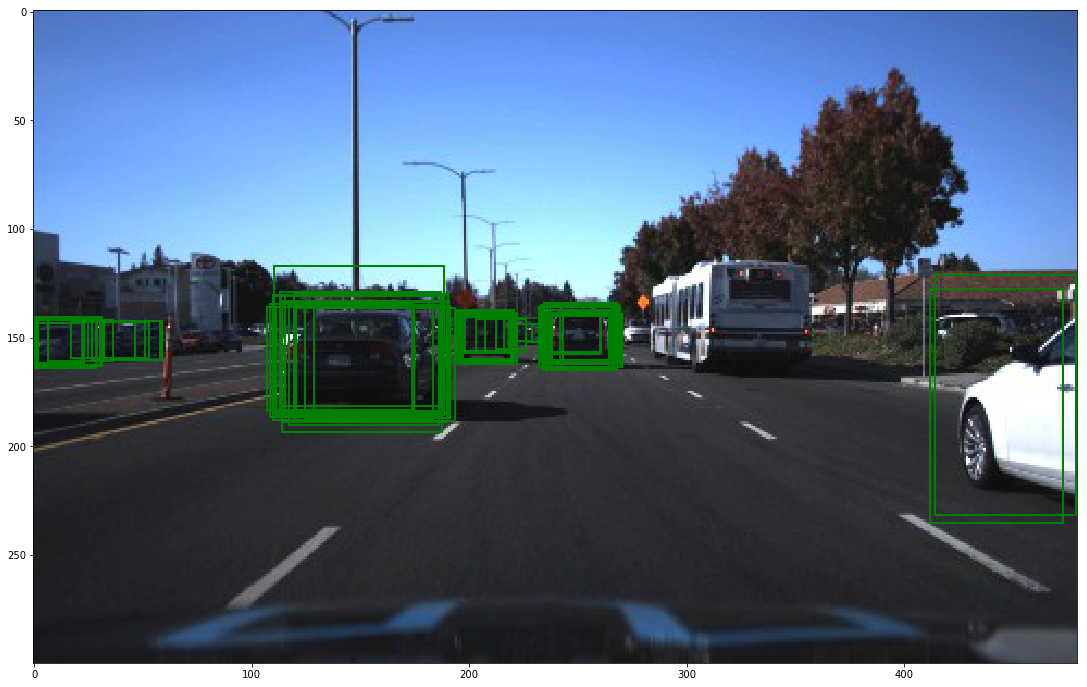

In [62]:
plt.figure(figsize=(20,12))
plt.imshow(X[0])

current_axis = plt.gca()

for box in y_pred_decoded[0]:
    current_axis.add_patch(plt.Rectangle((box[0], box[2]), box[1]-box[0], box[3]-box[2], color='green', fill=False, linewidth=2))

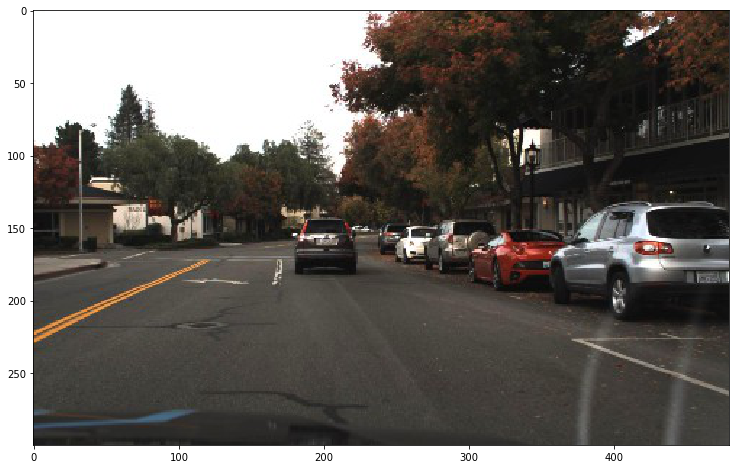

In [14]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

%matplotlib inline

img = mpimg.imread("./data/1478900910256548477.jpg")

plt.figure(figsize=(16,8))
plt.imshow(img)